In [30]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Paths to your data directories
train_path = r"H:\2.vgg19 image procced\preprocced_data_with_split\train"
test_path = r"H:\2.vgg19 image procced\preprocced_data_with_split\test"
val_path = r"H:\2.vgg19 image procced\preprocced_data_with_split\val"
IMG_SIZE = (224, 224)  # Adjusted for VGG19 input size

# Directory to save models and history
save_dir = r"H:\1.organized\allModel"

# Set hyperparameters
batch_size = 32
num_classes = 105
epochs = 25

# Create data generators for image preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Data generators for training, testing, and validation data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Keep the order for evaluation
)
validation_generator = test_datagen.flow_from_directory(
    val_path,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG19 model
base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers except the last 3 layers
for layer in base_model_vgg19.layers[:-3]:
    layer.trainable = False

# Create a custom top classifier for the number of classes using VGG19
model_vgg19 = models.Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(layers.Flatten())
model_vgg19.add(layers.Dense(2048, activation='relu'))
model_vgg19.add(layers.Dropout(0))
model_vgg19.add(layers.Dense(num_classes, activation='softmax'))

model_vgg19.summary()

# Compile VGG19 model
model_vgg19.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define the checkpoint callback to save the model
checkpoint_path = os.path.join(save_dir, '2.vgg19_model.h5')
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)



Found 8725 images belonging to 105 classes.
Found 1837 images belonging to 105 classes.
Found 1972 images belonging to 105 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 2048)              51382272  
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 105)               215145    
                                                                 
Total params: 71,621,801
Trainable params: 56,317,033


In [31]:
# Train the model and save the history
history_vgg19 = model_vgg19.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint]
)

# Save model architecture to JSON (for future use in prediction)
model_json = model_vgg19.to_json()
with open(os.path.join(save_dir, '2.model_vgg19.json'), 'w') as json_file:
    json_file.write(model_json)

# Save label mapping as JSON (assuming you have `train_generator.class_indices`)
label_map = train_generator.class_indices
with open(os.path.join(save_dir, '2.vgg19label_map.json'), 'w') as json_file:
    json.dump(label_map, json_file)



Epoch 1/25
272/272 [==============================] - ETA: 0s - loss: 2.3393 - accuracy: 0.4521
Epoch 1: val_loss improved from inf to 0.37210, saving model to H:\1.organized\allModel\2.vgg19_model.h5
272/272 [==============================] - 72s 261ms/step - loss: 2.3393 - accuracy: 0.4521 - val_loss: 0.3721 - val_accuracy: 0.8960
Epoch 2/25
272/272 [==============================] - ETA: 0s - loss: 0.4613 - accuracy: 0.8648
Epoch 2: val_loss improved from 0.37210 to 0.15071, saving model to H:\1.organized\allModel\2.vgg19_model.h5
272/272 [==============================] - 72s 264ms/step - loss: 0.4613 - accuracy: 0.8648 - val_loss: 0.1507 - val_accuracy: 0.9565
Epoch 3/25
272/272 [==============================] - ETA: 0s - loss: 0.2214 - accuracy: 0.9345
Epoch 3: val_loss improved from 0.15071 to 0.06057, saving model to H:\1.organized\allModel\2.vgg19_model.h5
272/272 [==============================] - 73s 266ms/step - loss: 0.2214 - accuracy: 0.9345 - val_loss: 0.0606 - val_accu

In [40]:
# Evaluate the model on test data
test_loss, test_accuracy = model_vgg19.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Evaluate the model on validation data
val_loss, val_accuracy = model_vgg19.evaluate(validation_generator, verbose=1)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")



58/58 [==============================] - 6s 90ms/step - loss: 0.0090 - accuracy: 0.9967
Test Accuracy: 99.67%
62/62 [==============================] - 6s 90ms/step - loss: 0.0088 - accuracy: 0.9970
Validation Accuracy: 99.70%


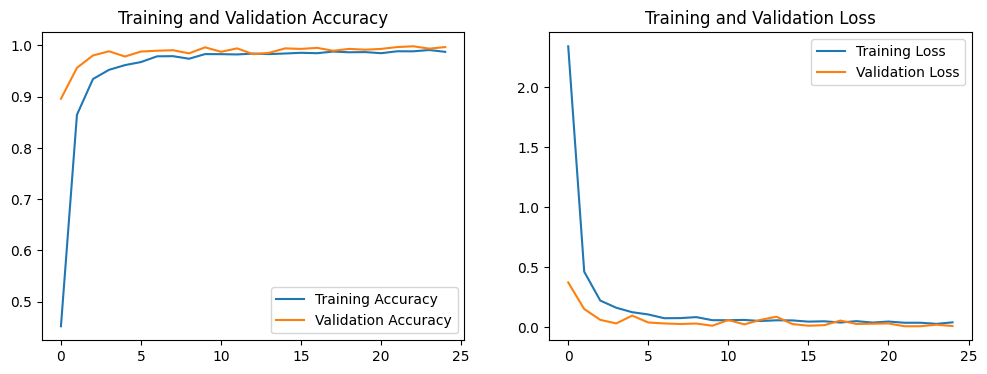

In [41]:

# Plot training & validation accuracy and loss values
acc = history_vgg19.history['accuracy']
val_acc = history_vgg19.history['val_accuracy']
loss = history_vgg19.history['loss']
val_loss = history_vgg19.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
# Predict on test data
test_generator.reset()
Y_pred = model_vgg19.predict(test_generator, test_generator.samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

# Classification report
class_report = classification_report(test_generator.classes, y_pred, target_names=list(label_map.keys()))
print(class_report)


58/58 [==============================] - 6s 100ms/step
              precision    recall  f1-score   support

       cow_1       1.00      1.00      1.00        14
      cow_10       1.00      1.00      1.00        25
     cow_101       1.00      1.00      1.00        10
     cow_110       1.00      1.00      1.00         8
     cow_112       1.00      1.00      1.00        21
     cow_113       1.00      1.00      1.00        21
     cow_124       1.00      1.00      1.00        18
     cow_126       1.00      1.00      1.00        18
     cow_127       1.00      1.00      1.00        27
     cow_129       1.00      1.00      1.00        11
      cow_13       1.00      1.00      1.00        25
     cow_140       1.00      1.00      1.00        12
     cow_157       1.00      1.00      1.00        14
     cow_158       1.00      1.00      1.00        10
     cow_168       1.00      1.00      1.00        18
      cow_17       1.00      1.00      1.00        20
     cow_179       1.00   

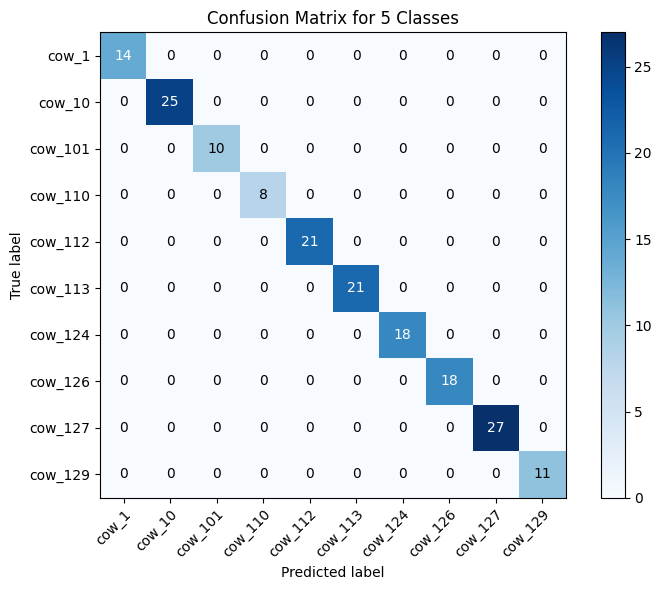

In [44]:



# Confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, y_pred)

# Display confusion matrix for 10 classes (e.g., first 5 classes)
selected_classes = list(label_map.keys())[:10]
conf_matrix_subset = conf_matrix[:10, :10]
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(conf_matrix_subset, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(conf_matrix_subset.shape[1]),
       yticks=np.arange(conf_matrix_subset.shape[0]),
       xticklabels=selected_classes, yticklabels=selected_classes,
       title='Confusion Matrix for 5 Classes',
       ylabel='True label',
       xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fmt = 'd'
thresh = conf_matrix_subset.max() / 2.
for i in range(conf_matrix_subset.shape[0]):
    for j in range(conf_matrix_subset.shape[1]):
        ax.text(j, i, format(conf_matrix_subset[i, j], fmt),
                ha="center", va="center",
                color="white" if conf_matrix_subset[i, j] > thresh else "black")
fig.tight_layout()
plt.show()


In [1]:
import os
import tkinter as tk
from tkinter import filedialog, messagebox
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import json

# Path to your saved model and label mapping
model_path = r"H:\1.organized\allModel\2.vgg19_model.h5"
label_map_path = r"H:\1.organized\allModel\2.vgg19label_map.json"

# Load label mapping
with open(label_map_path, 'r') as f:
    label_map = json.load(f)
    label_map = {v: k for k, v in label_map.items()}  # invert mapping to get class labels

# Load the saved model
model = load_model(model_path)

# Function to preprocess uploaded image
def preprocess_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale to [0,1]
    return img_array

# Function to handle image upload and prediction
def upload_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        try:
            img_array = preprocess_img(file_path)
            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction)
            class_label = label_map.get(str(predicted_class), "Unknown")
            messagebox.showinfo("Prediction Result", f"Predicted Class: {class_label}")
        except Exception as e:
            messagebox.showerror("Error", f"Error predicting image: {e}")

# Create tkinter GUI window
root = tk.Tk()
root.title("Cow Nose Print Recognition")

# Create and position widgets
label = tk.Label(root, text="Upload an image to predict:")
label.pack(pady=10)

upload_button = tk.Button(root, text="Upload Image", command=upload_image)
upload_button.pack(pady=10)

# Run the tkinter main loop
root.mainloop()


1/1 [==============================] - 0s 17ms/step


In [4]:
import os
import tkinter as tk
from tkinter import filedialog, messagebox
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import json
import cv2

# Paths to your saved model and label mapping
model_path = r"H:\1.organized\allModel\2.vgg19_model.h5"
label_map_path = r"H:\1.organized\allModel\2.vgg19label_map.json"

# Load label mapping
with open(label_map_path, 'r') as f:
    label_map = json.load(f)
    label_map = {int(k): v for k, v in label_map.items()}  # Ensure labels are correctly loaded as integers

# Load the saved model
model = load_model(model_path)

# Function to preprocess uploaded image
def preprocess_img(img_path):
    try:
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image file not found or could not be read: {img_path}")

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        equalized = cv2.equalizeHist(gray)
        gaussian_filtered = cv2.GaussianBlur(equalized, (5, 5), 0)
        resized_image = cv2.resize(gaussian_filtered, (224, 224))
        return resized_image
    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        return None

# Function to handle image upload and prediction
def upload_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        try:
            # Preprocess the uploaded image
            preprocessed_image = preprocess_img(file_path)
            if preprocessed_image is not None:
                # Reshape image for model prediction
                img_array = np.expand_dims(preprocessed_image, axis=0)
                img_array = img_array / 255.0  # Normalize to [0, 1]

                # Predict using the loaded model
                prediction = model.predict(img_array)
                predicted_class_idx = np.argmax(prediction)
                predicted_class = label_map.get(predicted_class_idx, "Unknown")

                # Show prediction result
                messagebox.showinfo("Prediction Result", f"Predicted Class: {predicted_class}")
        except Exception as e:
            messagebox.showerror("Error", f"Error predicting image: {e}")

# Create tkinter GUI window
root = tk.Tk()
root.title("Cow Nose Print Recognition")

# Create and position widgets
label = tk.Label(root, text="Upload an image to predict:")
label.pack(pady=10)

upload_button = tk.Button(root, text="Upload Image", command=upload_image)
upload_button.pack(pady=10)

# Run the tkinter main loop
root.mainloop()


ValueError: invalid literal for int() with base 10: 'cow_1'

In [3]:
print(label_map)


{0: 'cow_1', 1: 'cow_10', 2: 'cow_101', 3: 'cow_110', 4: 'cow_112', 5: 'cow_113', 6: 'cow_124', 7: 'cow_126', 8: 'cow_127', 9: 'cow_129', 10: 'cow_13', 11: 'cow_140', 12: 'cow_157', 13: 'cow_158', 14: 'cow_168', 15: 'cow_17', 16: 'cow_179', 17: 'cow_190', 18: 'cow_196', 19: 'cow_2', 20: 'cow_201', 21: 'cow_210', 22: 'cow_212', 23: 'cow_217', 24: 'cow_223', 25: 'cow_224', 26: 'cow_235', 27: 'cow_24', 28: 'cow_246', 29: 'cow_247', 30: 'cow_248', 31: 'cow_249', 32: 'cow_252', 33: 'cow_255', 34: 'cow_257', 35: 'cow_258', 36: 'cow_259', 37: 'cow_261', 38: 'cow_262', 39: 'cow_263', 40: 'cow_264', 41: 'cow_265', 42: 'cow_266', 43: 'cow_267', 44: 'cow_268', 45: 'cow_269', 46: 'cow_27', 47: 'cow_270', 48: 'cow_271', 49: 'cow_273', 50: 'cow_274', 51: 'cow_275', 52: 'cow_279', 53: 'cow_280', 54: 'cow_283', 55: 'cow_285', 56: 'cow_286', 57: 'cow_287', 58: 'cow_288', 59: 'cow_289', 60: 'cow_292', 61: 'cow_293', 62: 'cow_295', 63: 'cow_296', 64: 'cow_298', 65: 'cow_299', 66: 'cow_300', 67: 'cow_301'